# SATURDAY - TW INDIVIDUAL BIDDING STRATEGY

### SETUP

In [1]:
import time
beginning_time = time.time()

import sys
sys.path.append("../Code/")
from utils import performance

import os
DATA_DIR = os.path.join('..', 'Data')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

start = time.time()

def timtime():
    print(">",int((time.time()- start)//60), "minutes elapsed")

#----------------------------------------------------#    
    
train_X = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1')), 
                     pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2'))])
train_y = pd.read_pickle(os.path.join(DATA_DIR, 'train_y'))
valid_X = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X'))
valid_y = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y'))

test_X = pd.read_pickle(os.path.join(DATA_DIR, 'test_X'))

### LOAD MODELS

_Using Logistic Regression as CTR predictor_

In [2]:
import pickle

GMM_filename = "../Models/SatGMM4"
with open(GMM_filename, 'rb') as file:
    GMM = pickle.load(file)
    

dist_pred_filename = "../Models/SatXGDistPred2"
with open(dist_pred_filename, 'rb') as file:
    dp = pickle.load(file)
    

ctr_pred_filename = "../Models/clf3.pkl"
with open(ctr_pred_filename, 'rb') as file:
    ctr = pickle.load(file)

### Investigate the market price distributions

In [3]:
from scipy.stats import norm

In [4]:
d1 = {"mu":GMM.means_[0][0], "sig":GMM.covariances_[0][0][0]}
d2 = {"mu":GMM.means_[1][0], "sig":GMM.covariances_[1][0][0]}
d3 = {"mu":GMM.means_[2][0], "sig":GMM.covariances_[2][0][0]}
d4 = {"mu":GMM.means_[3][0], "sig":GMM.covariances_[3][0][0]}

In [5]:
win_prob = np.linspace(0.000001, 0.999999, 1000)

pp1 = norm.ppf(q=win_prob, loc=d1["mu"], scale=d1["sig"])
pp2 = norm.ppf(q=win_prob, loc=d2["mu"], scale=d2["sig"])
pp3 = norm.ppf(q=win_prob, loc=d3["mu"], scale=d3["sig"])
pp4 = norm.ppf(q=win_prob, loc=d4["mu"], scale=d4["sig"])

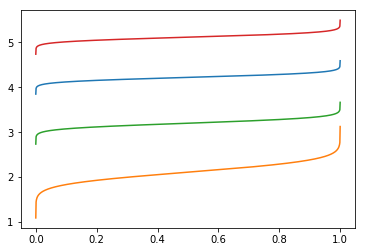

In [150]:
plt.plot(win_prob, pp1)
plt.plot(win_prob, pp2)
plt.plot(win_prob, pp3)
plt.plot(win_prob, pp4)


plt.show()

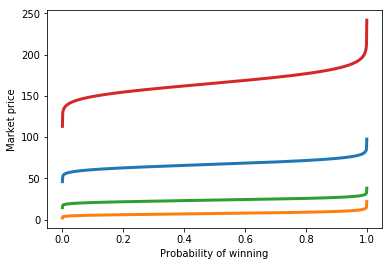

In [203]:
plt.plot(win_prob, np.expm1(pp1), linewidth=3.0)
plt.plot(win_prob, np.expm1(pp2), linewidth=3.0)
plt.plot(win_prob, np.expm1(pp3), linewidth=3.0)
plt.plot(win_prob, np.expm1(pp4), linewidth=3.0)
plt.xlabel('Probability of winning')
plt.ylabel('Market price')

plt.show()

In [7]:
base_prices = []
for p in [pp1,pp2,pp3,pp4]:
    base_prices.append(np.max(np.expm1(p)))    
print(base_prices)

[97.500043508853423, 21.779086415373719, 38.022667032381108, 241.60718474562606]


In [8]:
new_base_prices = [98, 100, 100, 240]

In [9]:
from scipy.sparse import csr_matrix
train_X = csr_matrix(train_X) 
valid_X = csr_matrix(valid_X)
valid_distributions = dp.predict(valid_X)

In [159]:
N = np.shape(valid_X)[0]
valid_base_prices = np.zeros(N)
for i in range(N):
    valid_base_prices[i] = new_base_prices[valid_distributions[i]]

In [160]:
np.sum(valid_base_prices>valid_y.payprice)/N

0.84267171177099609

In [161]:
np.sum(valid_base_prices*valid_ctr_prob>valid_y.payprice)/N

0.20546845438841821

### Make predictions - - - - - LINEAR REGRESSION

In [162]:
from utils import new_performance

In [163]:
Q = valid_base_prices*valid_ctr_prob

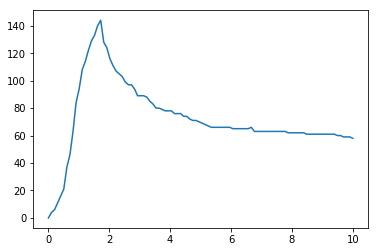

Best number of clicks: 144.0
Best base bid: 1.71717171717


In [164]:
##### SCALE THE BIDS BY THE SAME CONSTANT #######

min_alpha = 0
max_alpha = 10
n_alphas = 100
alphas = np.linspace(min_alpha, max_alpha, n_alphas)

clicks = np.zeros_like(alphas)

for i, a in zip(range(n_alphas), alphas):
    bids = a*Q
    _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
    clicks[i] = c
    
#### plot ####
plt.plot(alphas, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", alphas[np.argmax(clicks)])

In [165]:
##### SCALE THE BIDS BY THE SAME MULTIPLE OF THEIR STANDARD DEVIATION #######

valid_std = np.zeros(N)
for i in range(N):
    valid_std[i] = GMM.covariances_[valid_distributions[i],0,0]
    
valid_std = np.expm1(valid_std)

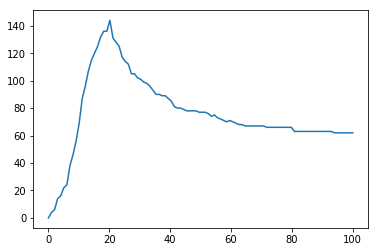

Best number of clicks: 144.0
Best base bid: 20.202020202


In [166]:
min_alpha = 0
max_alpha = 100
n_alphas = 100
alphas = np.linspace(min_alpha, max_alpha, n_alphas)

clicks = np.zeros_like(alphas)

for i, a in zip(range(n_alphas), alphas):
    bids = Q * a*valid_std
    _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
    clicks[i] = c
    
#### plot ####
plt.plot(alphas, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", alphas[np.argmax(clicks)])

### Make predictions - - - - - XGBOOST

In [167]:
# TODO #
ctr_pred_filename = "../Models/tim_xgb_click.pkl"
with open(ctr_pred_filename, 'rb') as file:
    ctr2 = pickle.load(file)

In [168]:
valid_ctr_prob_2 = ctr2.predict(valid_X)

In [169]:
QQ = valid_base_prices*valid_ctr_prob_2

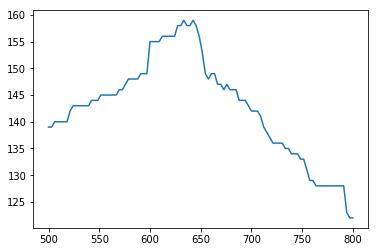

Best number of clicks: 159.0
Best base bid: 633.333333333


In [170]:
##### SCALE THE BIDS BY THE SAME CONSTANT #######

min_alpha = 500
max_alpha = 800
n_alphas = 100
alphas = np.linspace(min_alpha, max_alpha, n_alphas)

clicks = np.zeros_like(alphas)

for i, a in zip(range(n_alphas), alphas):
    bids = a*QQ
    _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
    clicks[i] = c
    
#### plot ####
plt.plot(alphas, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", alphas[np.argmax(clicks)])

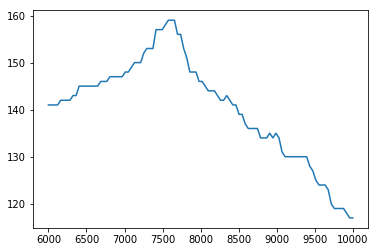

Best number of clicks: 159.0
Best base bid: 7575.75757576


In [171]:
##### SCALE THE BIDS BY THE SAME MULTIPLE OF THEIR STANDARD DEVIATION #######

min_alpha = 6000
max_alpha = 10000
n_alphas = 100
alphas = np.linspace(min_alpha, max_alpha, n_alphas)

clicks = np.zeros_like(alphas)

for i, a in zip(range(n_alphas), alphas):
    bids = QQ * a*valid_std
    _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
    clicks[i] = c
    
#### plot ####
plt.plot(alphas, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", alphas[np.argmax(clicks)])

In [122]:
stds = np.expm1([d1["sig"], d2["sig"], d3["sig"], d4["sig"]])

In [123]:
stds

array([ 0.08118873,  0.23858139,  0.10266261,  0.08270507])

In [151]:
##### SCALE THE BIDS BY DIFFERENT MULTIPLE OF THEIR STANDARD DEVIATION #######
#### (DEPENDENT ON THE DISTRIUBTION THEY BELONG TO) #######

size_of_search = 1000
abcd = np.random.uniform(low=7000, high=9000, size=(size_of_search, 4))

clicks = np.zeros(size_of_search)

for s in range(size_of_search):
    bids = QQ.copy()
    
    a = abcd[i,0];    b = abcd[i,1]  
    c = abcd[i,2];    d = abcd[i,3]
        
    bids[valid_distributions==0] *= stds[0] * a
    bids[valid_distributions==1] *= stds[1] * b  
    bids[valid_distributions==2] *= stds[2] * c  
    bids[valid_distributions==3] *= stds[3] * d
    
    _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
    clicks[i] = c

In [152]:
np.max(clicks)

157.0

In [153]:
abcd[np.argmax(clicks)]

array([ 8779.76343685,  7876.10768806,  8275.85215836,  7117.4513638 ])

In [147]:
np.max(clicks)

150.0

In [148]:
abcd[np.argmax(clicks)]

array([ 7266.76432589,  6653.66757789,  8220.45364968,  8343.15124425])

In [144]:
np.max(clicks)

157.0

In [154]:
abcd[np.argmax(clicks)]

array([ 8779.76343685,  7876.10768806,  8275.85215836,  7117.4513638 ])

### Analysis

In [155]:
bids = QQ.copy()
    
a,b,c,d = [8779.76343685, 7876.10768806, 8275.85215836, 7117.4513638]

bids[valid_distributions==0] *= stds[0] * a
bids[valid_distributions==1] *= stds[1] * b  
bids[valid_distributions==2] *= stds[2] * c  
bids[valid_distributions==3] *= stds[3] * d

_, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=True)

               CTR: (0.1142)%
        num_clicks: 157
             spend: 6128149 (98.05)%
              aCPM: 20.1633593814
              aCPC: 39.0327961783
num_in_budget_wins: 137470
 ads_within_budget: 303925


In [158]:
np.min(bids)

18.847486103153479

In [157]:
np.max(bids)

99882.067120977081

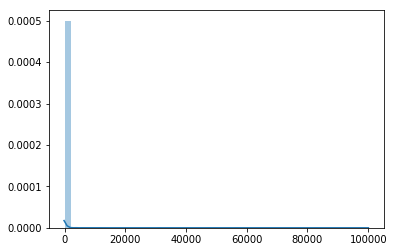

In [156]:
sns.distplot(bids)
plt.show()

### CHECK LOG LOSS AND ROC on the validation set

In [172]:
from sklearn.metrics import log_loss, roc_auc_score

In [177]:
log_loss(valid_y.click, ctr.predict_proba(valid_X)[:,1])

0.43892050758291745

In [180]:
roc_auc_score(valid_y.click, ctr.predict_proba(valid_X)[:,1])

0.85063574733921665

In [178]:
log_loss(valid_y.click, ctr2.predict(valid_X))

0.0040929725290596098

In [181]:
roc_auc_score(valid_y.click, ctr2.predict(valid_X))

0.87417814884282752

In [182]:
from scipy.stats import logistic

In [193]:
logistic([1,2,3,4])

In [194]:
logistic.pdf(np.random.rand(5))

array([ 0.20292237,  0.22594954,  0.24639432,  0.24660698,  0.24289812])

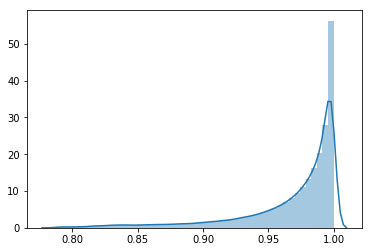

In [198]:
sns.distplot(4*logistic.pdf(ctr.predict_proba(valid_X)[:,1]))
plt.show()

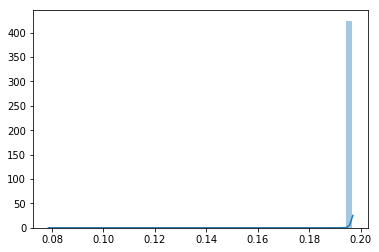

In [195]:
sns.distplot(logistic.pdf(np.exp(ctr2.predict(valid_X))))
plt.show()

In [186]:
np.exp(5)

148.4131591025766